`Preparing the Response Variable and relevant lagged predictors - done`

Summary of steps:
- For each numerical variable, substitutied missing values with zero and created a missingness indicator variable
    - 11 columns created
    - significant missing values of ghg_change renewable imputed with zero
    - Taking the log + 1 of all the numerical variables to make it more normally distributed
- Preparing the response variable:
    - Created a categorical variable for the response variable based on ghg_change_real indicating whether there has been a decrease or zero/increase in emissions
    - Lagged the response variable by 1 year to align with prediction
    - Note that I am assuming that the change in year x corresponds to the change from year x-1 to year x, therefore by lagging the response I am aligning, at year x, the change in year x to the change in year x+1
    - This implies that for 2022 data (which is the most recent data), there is no response variable because we do not have the change in emissions from 2022 to 2023 yet
    - Hence, I believe that data untill 2020 should be used for training and validation, and 2021 data should be used for testing, as effectively we are predicting the change in emissions from 2021 to 2022 using 2021 data
- Dropping rows where the response variable is more than 3 standard deviations away from the mean
    - This is to remove outliers

In [714]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score

In [715]:
cdp_ghg_change = pd.read_stata("../../data/CDP Cleaning/cleaned outputs/cdp_ghg_change.dta")
cdp_ghg_change.shape

(33071, 20)

In [716]:
cdp_ghg_change.columns

Index(['id', 'year', 'ghg_change', 'ghg2_based_on', 'ghg_change_acquisitions',
       'ghg_change_boundary', 'ghg_change_divestment',
       'ghg_change_ems_reduction', 'ghg_change_mergers',
       'ghg_change_methodology', 'ghg_change_other', 'ghg_change_output',
       'ghg_change_unidentified', 'ghg_change_physical',
       'ghg_change_renewable', 'ghg_change_total', 'ghg_change_real',
       'ghg_change_structure', 'ghg_change_measure', 'ghg_change_othergroup'],
      dtype='object')

In [717]:
[cdp_ghg_change['id'] == 7164]

[0        False
 1        False
 2        False
 3        False
 4        False
          ...  
 33066    False
 33067    False
 33068    False
 33069    False
 33070    False
 Name: id, Length: 33071, dtype: bool]

In [718]:
cdp_ghg_change

,id,year,ghg_change,ghg2_based_on,ghg_change_acquisitions,ghg_change_boundary,ghg_change_divestment,ghg_change_ems_reduction,ghg_change_mergers,ghg_change_methodology,ghg_change_other,ghg_change_output,ghg_change_unidentified,ghg_change_physical,ghg_change_renewable,ghg_change_total,ghg_change_real,ghg_change_structure,ghg_change_measure,ghg_change_othergroup
0,44,2011.0,decrease,,0.0,0.0,0.0,-11.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-11.0,-11.0,0.0,0.0,0.0
1,44,2012.0,decrease,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-25.0,NaN,-25.0,0.0,0.0,0.0,-25.0
2,44,2013.0,decrease,,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-17.0,NaN,-19.0,-1.0,0.0,-1.0,-17.0
3,44,2014.0,decrease,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-29.0,NaN,-29.0,0.0,0.0,0.0,-29.0
4,44,2016.0,decrease,location,0.0,0.0,0.0,0.0,0.0,0.0,-4.0,0.0,0.0,0.0,NaN,-4.0,0.0,0.0,0.0,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33066,895873,2022.0,decrease,location,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33067,895909,2022.0,N/A,N/A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33068,896044,2022.0,N/A,N/A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33069,896120,2022.0,N/A,N/A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [719]:
cdp_ghg_change['ghg_change_total'].describe()

count    33071.000000
mean        -0.561079
std         44.022980
min      -1700.000000
25%         -6.000000
50%          0.000000
75%          0.700000
max       1113.000000
Name: ghg_change_total, dtype: float64

In [720]:
((cdp_ghg_change['ghg_change_real'] - (cdp_ghg_change['ghg_change_renewable'].fillna(0) + cdp_ghg_change['ghg_change_ems_reduction'].fillna(0))) > 0.01).mean()

0.0

In [721]:
# count number of missing values for each variable
cdp_ghg_change.isnull().sum()

id                              0
year                            0
ghg_change                      0
ghg2_based_on                   0
ghg_change_acquisitions      1143
ghg_change_boundary          1162
ghg_change_divestment        1124
ghg_change_ems_reduction     1247
ghg_change_mergers           1108
ghg_change_methodology       1161
ghg_change_other             1198
ghg_change_output            1235
ghg_change_unidentified      1143
ghg_change_physical          2484
ghg_change_renewable        12818
ghg_change_total                0
ghg_change_real                 0
ghg_change_structure            0
ghg_change_measure              0
ghg_change_othergroup           0
dtype: int64

In [722]:
cdp_ghg_change.head()

,id,year,ghg_change,ghg2_based_on,ghg_change_acquisitions,ghg_change_boundary,ghg_change_divestment,ghg_change_ems_reduction,ghg_change_mergers,ghg_change_methodology,ghg_change_other,ghg_change_output,ghg_change_unidentified,ghg_change_physical,ghg_change_renewable,ghg_change_total,ghg_change_real,ghg_change_structure,ghg_change_measure,ghg_change_othergroup
0,44,2011.0,decrease,,0.0,0.0,0.0,-11.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-11.0,-11.0,0.0,0.0,0.0
1,44,2012.0,decrease,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-25.0,NaN,-25.0,0.0,0.0,0.0,-25.0
2,44,2013.0,decrease,,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-17.0,NaN,-19.0,-1.0,0.0,-1.0,-17.0
3,44,2014.0,decrease,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-29.0,NaN,-29.0,0.0,0.0,0.0,-29.0
4,44,2016.0,decrease,location,0.0,0.0,0.0,0.0,0.0,0.0,-4.0,0.0,0.0,0.0,NaN,-4.0,0.0,0.0,0.0,-4.0


In [723]:
cdp_ghg_change

,id,year,ghg_change,ghg2_based_on,ghg_change_acquisitions,ghg_change_boundary,ghg_change_divestment,ghg_change_ems_reduction,ghg_change_mergers,ghg_change_methodology,ghg_change_other,ghg_change_output,ghg_change_unidentified,ghg_change_physical,ghg_change_renewable,ghg_change_total,ghg_change_real,ghg_change_structure,ghg_change_measure,ghg_change_othergroup
0,44,2011.0,decrease,,0.0,0.0,0.0,-11.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-11.0,-11.0,0.0,0.0,0.0
1,44,2012.0,decrease,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-25.0,NaN,-25.0,0.0,0.0,0.0,-25.0
2,44,2013.0,decrease,,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-17.0,NaN,-19.0,-1.0,0.0,-1.0,-17.0
3,44,2014.0,decrease,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-29.0,NaN,-29.0,0.0,0.0,0.0,-29.0
4,44,2016.0,decrease,location,0.0,0.0,0.0,0.0,0.0,0.0,-4.0,0.0,0.0,0.0,NaN,-4.0,0.0,0.0,0.0,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33066,895873,2022.0,decrease,location,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33067,895909,2022.0,N/A,N/A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33068,896044,2022.0,N/A,N/A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33069,896120,2022.0,N/A,N/A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [724]:
# creating a nonzero categories count for changes in emisisons
cdp_ghg_change['ghg_change_nonzero_count'] = np.sum(np.abs(cdp_ghg_change.iloc[:, 4:15] - 0) > 0.001, axis=1)

In [725]:
output =  cdp_ghg_change['ghg_change_output']

In [726]:
cdp_ghg_change.drop(cdp_ghg_change.iloc[:, 4:15].columns, axis=1, inplace=True)

In [727]:
cdp_ghg_change['ghg_change_output'] = output

In [728]:
# dropping ghg change, I can infer it from other predictors and also based on since it is not significant
cdp_ghg_change.drop(columns=['ghg_change', 'ghg2_based_on'], axis = 1, inplace=True)

In [729]:
# check for rows with same year and id
cdp_ghg_change[cdp_ghg_change.duplicated(subset=['id', 'year'], keep=False)]

,id,year,ghg_change_total,ghg_change_real,ghg_change_structure,ghg_change_measure,ghg_change_othergroup,ghg_change_nonzero_count,ghg_change_output


In [730]:
cdp_ghg_change.isna().mean()

id                          0.000000
year                        0.000000
ghg_change_total            0.000000
ghg_change_real             0.000000
ghg_change_structure        0.000000
ghg_change_measure          0.000000
ghg_change_othergroup       0.000000
ghg_change_nonzero_count    0.000000
ghg_change_output           0.037344
dtype: float64

In [731]:
# for all columns in df that are not id, year if column has missing values, set the value to 0 and create a new column with _missing indicator
for col in cdp_ghg_change.columns:
    if col not in ['id', 'year'] and cdp_ghg_change[col].isna().sum() > 0:
        cdp_ghg_change[col + '_missing'] = cdp_ghg_change[col].apply(lambda x: 1 if pd.isna(x) else 0)
        cdp_ghg_change[col] = cdp_ghg_change[col].fillna(0)

In [732]:
# create a new column with real_increase or real_decrease or real_no_change if the change is positive, negative or zero in ghg_change_real
cdp_ghg_change['ghg_change_real_cat'] = cdp_ghg_change['ghg_change_real'].apply(lambda x: 1 if x < 0 else 0)

**Counting rows where the response variable is more or less than 3 std from the mean**
- checking the number of rows
- I don't believe it does make sense to drop the relevant ones as they can still be useful in training my model

In [733]:
(np.abs(cdp_ghg_change['ghg_change_real']) > 300).sum()

22

In [734]:
# filter out observation where the percentage change is more than 50%
cdp_ghg_change = cdp_ghg_change.loc[np.abs(cdp_ghg_change['ghg_change_real']) < 50]

In [735]:
# counting the number of rows which are more than three standard deviations away from the mean
(cdp_ghg_change[(cdp_ghg_change['ghg_change_real'] - cdp_ghg_change['ghg_change_real'].mean()) / cdp_ghg_change['ghg_change_real'].std() > 5]['id'].count(),
cdp_ghg_change[(cdp_ghg_change['ghg_change_real'] - cdp_ghg_change['ghg_change_real'].mean()) / cdp_ghg_change['ghg_change_real'].std() < -5]['id'].count())


(28, 230)

In [736]:
# count the categories for ghg_change_real_cat percentages
cdp_ghg_change['ghg_change_real_cat'].value_counts(normalize=True)

ghg_change_real_cat
0    0.521067
1    0.478933
Name: proportion, dtype: float64

In [737]:
cdp_ghg_change['ghg_change_real_cat'].value_counts(normalize=True)

ghg_change_real_cat
0    0.521067
1    0.478933
Name: proportion, dtype: float64

**Creating the response variable**

In [738]:
# Sort the DataFrame by 'id' and 'year' to ensure correct ordering
cdp_ghg_change = cdp_ghg_change.sort_values(by=['id', 'year'])

# Shift the response variable within each 'id' group
cdp_ghg_change['ghg_change_real_cat_next'] = cdp_ghg_change.groupby('id')['ghg_change_real_cat'].shift(-1)
cdp_ghg_change['ghg_change_real_next'] = cdp_ghg_change.groupby('id')['ghg_change_real'].shift(-1)

In [739]:
(cdp_ghg_change.dropna()['ghg_change_real_cat_next'] == cdp_ghg_change.dropna()['ghg_change_real_cat']).value_counts(normalize=True)

True     0.772282
False    0.227718
Name: proportion, dtype: float64

In [740]:
cdp_ghg_change['ghg_change_real_cat_next'].value_counts(normalize=True)

ghg_change_real_cat_next
1.0    0.630818
0.0    0.369182
Name: proportion, dtype: float64

/var/folders/z7/jmcsyl9x47zdw6n1xd2_16jh0000gn/T/ipykernel_12356/3936605058.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cdp_ghg_change.loc[np.abs(cdp_ghg_change['ghg_change_real']) < 20, 'ghg_change_real'])


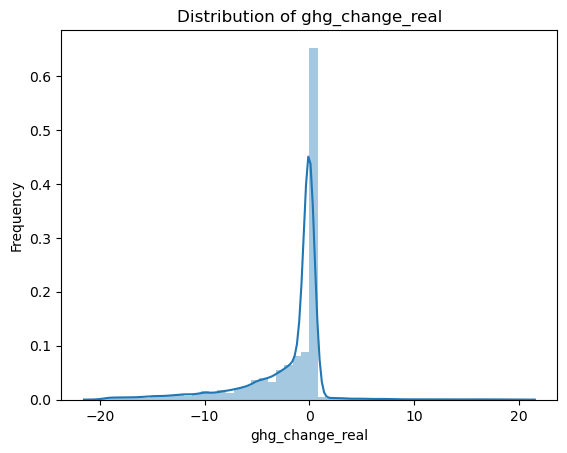

In [741]:
# plot distribution of ghg_change_real, remove outliers more than 3 standard deviations away from the mean
sns.distplot(cdp_ghg_change.loc[np.abs(cdp_ghg_change['ghg_change_real']) < 20, 'ghg_change_real'])
plt.title('Distribution of ghg_change_real')
plt.xlabel('ghg_change_real')
plt.ylabel('Frequency')
plt.show()

**Creating Dummies**
- one hot encoding the categories: ghg_change and ghg2_based_on

In [742]:
cdp_ghg_change

,id,year,ghg_change_total,ghg_change_real,ghg_change_structure,ghg_change_measure,ghg_change_othergroup,ghg_change_nonzero_count,ghg_change_output,ghg_change_output_missing,ghg_change_real_cat,ghg_change_real_cat_next,ghg_change_real_next
0,44,2011.0,-11.0,-11.0,0.0,0.0,0.0,1,0.0,0,1,0.0,0.000000
1,44,2012.0,-25.0,0.0,0.0,0.0,-25.0,1,0.0,0,0,1.0,-1.000000
2,44,2013.0,-19.0,-1.0,0.0,-1.0,-17.0,3,0.0,0,1,0.0,0.000000
3,44,2014.0,-29.0,0.0,0.0,0.0,-29.0,1,0.0,0,0,0.0,0.000000
4,44,2016.0,-4.0,0.0,0.0,0.0,-4.0,1,0.0,0,0,1.0,-39.700001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33066,895873,2022.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,NaN,NaN
33067,895909,2022.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,NaN,NaN
33068,896044,2022.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,NaN,NaN
33069,896120,2022.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,NaN,NaN


In [743]:
cdp_ghg_change.columns

Index(['id', 'year', 'ghg_change_total', 'ghg_change_real',
       'ghg_change_structure', 'ghg_change_measure', 'ghg_change_othergroup',
       'ghg_change_nonzero_count', 'ghg_change_output',
       'ghg_change_output_missing', 'ghg_change_real_cat',
       'ghg_change_real_cat_next', 'ghg_change_real_next'],
      dtype='object')

**Dropping rows in which the lagged response is nan: that is firms in 2022 or firms who stopped reporting**

- note that there are missing values across all years: this is due to the fact that if a firm stops reporting in 2021 then for that year we will have a missing values: I have checked the result and indeed the number of dropped values correspond to the cases in which a firm stops reporting on that year.
- I will drop firms who stop reporting as realistically they are not existing anymore or they are not relevant for the purpose of the analysis
- note how there are 8161 firms in 2022, which corresponds to 8161 firms whose predictions will be avaliable when the 2023 data will come out

In [744]:
# counting the number of NA variables in the response
cdp_ghg_change.isna().drop('year', axis = 1).groupby(cdp_ghg_change['year'])['ghg_change_real_cat_next'].sum()

year
2011.0      91
2012.0     125
2013.0      78
2014.0     102
2015.0     167
2016.0     150
2017.0     184
2018.0      99
2019.0     108
2020.0     118
2021.0    1681
2022.0    8124
Name: ghg_change_real_cat_next, dtype: int64

In [745]:
# counting how many firms stop reporting every year
cdp_ghg_change.groupby('id')['year'].apply(lambda x: x.max()).value_counts()

year
2022.0    8124
2021.0    1681
2017.0     184
2015.0     167
2016.0     150
2012.0     125
2020.0     118
2019.0     108
2014.0     102
2018.0      99
2011.0      91
2013.0      78
Name: count, dtype: int64

In [746]:
# dropping na rows
# cdp_ghg_change.dropna(inplace=True)

In [747]:
cdp_ghg_change.shape

(32255, 13)

In [748]:
cdp_ghg_change['ghg_change_output_missing'].value_counts()

ghg_change_output_missing
0    31023
1     1232
Name: count, dtype: int64

In [749]:
cdp_ghg_change.describe()

,id,year,ghg_change_total,ghg_change_real,ghg_change_structure,ghg_change_measure,ghg_change_othergroup,ghg_change_nonzero_count,ghg_change_output,ghg_change_output_missing,ghg_change_real_cat,ghg_change_real_cat_next,ghg_change_real_next
count,32255.000000,32255.000000,32255.000000,32255.000000,32255.000000,32255.000000,32255.000000,32255.000000,32255.000000,32255.000000,32255.000000,21228.000000,21228.000000
mean,187564.328290,2018.243408,0.653218,-3.065109,0.678736,1.364287,0.441233,1.563510,1.234071,0.038196,0.478933,0.630818,-3.977447
std,333752.588092,3.629903,38.298248,7.217334,13.697059,21.377779,22.108339,1.559546,15.190040,0.191671,0.499564,0.482595,7.841396
min,44.000000,2011.000000,-1700.000000,-49.900002,-773.760010,-356.000000,-1700.000000,0.000000,-760.000000,0.000000,0.000000,0.000000,-49.900002
25%,9897.000000,2015.000000,-5.260000,-3.470000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.000000
50%,20575.000000,2019.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-1.060000
75%,57239.000000,2022.000000,0.800000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,896123.000000,2022.000000,1010.000000,49.860001,705.200012,953.000000,896.000000,10.000000,716.000000,1.000000,1.000000,1.000000,45.000000


In [750]:
cdp_ghg_change.drop(columns=['ghg_change_real_cat_next', 'ghg_change_real_cat'], axis = 1, inplace=True)

In [751]:
# save the data to csv
cdp_ghg_change.to_csv('../../data/processed/cdp_ghg_change_processed.csv', index=False)

**Final dimensions for the response variable and lagged set: 21354 observations with 38 columns**

**Observations**

- there should be no future leakage in the dataset
- recall that you are not using 2022 data. The dataset can be used later jsut to make preidctions without training the model, doing that requires a similar data pipeline where this time I export the CSV of rows that only belong to 2022
- this file has been saved as well and named

In [752]:
cdp_ghg_change.tail()

,id,year,ghg_change_total,ghg_change_real,ghg_change_structure,ghg_change_measure,ghg_change_othergroup,ghg_change_nonzero_count,ghg_change_output,ghg_change_output_missing,ghg_change_real_next
33066,895873,2022.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN
33067,895909,2022.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN
33068,896044,2022.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN
33069,896120,2022.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN
33070,896123,2022.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN


In [753]:
cdp_ghg_change[cdp_ghg_change['id'] == 7164]

,id,year,ghg_change_total,ghg_change_real,ghg_change_structure,ghg_change_measure,ghg_change_othergroup,ghg_change_nonzero_count,ghg_change_output,ghg_change_output_missing,ghg_change_real_next
6152,7164,2011.0,16.799999,-3.40,0.00,0.00,0.0,2,20.2,0,-4.40
6153,7164,2012.0,1.700000,-4.40,0.00,0.90,0.0,3,5.2,0,-3.00
6154,7164,2013.0,-4.000000,-3.00,0.00,0.00,-1.0,2,0.0,0,-4.00
6155,7164,2014.0,5.000000,-4.00,0.00,2.00,1.5,4,5.5,0,-4.00
6156,7164,2015.0,-2.300000,-4.00,0.79,-1.49,2.0,7,0.4,0,-5.20
6157,7164,2016.0,-7.799999,-5.20,0.00,-2.60,0.3,4,-0.3,0,-4.50
6158,7164,2017.0,3.500000,-4.50,0.00,1.50,1.2,4,5.3,0,-6.00
6159,7164,2018.0,-23.400000,-6.00,-11.00,-6.00,0.6,7,-1.0,0,-7.00
6160,7164,2019.0,-6.000000,-7.00,0.00,0.00,4.0,4,-3.0,0,-8.00
6161,7164,2020.0,-4.950000,-8.00,0.00,0.05,7.0,6,-4.0,0,-3.10
